Importing libraries and setting up environment

In [1]:
import sympy
sympy.init_printing()
import numpy
import pylab
import h5py
import scipy.optimize
import matplotlib

"Normal" range:

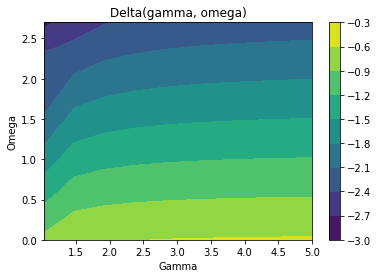

<Figure size 432x288 with 0 Axes>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
gamma = np.array([1.03      , 1.47111111, 1.91222222, 2.35333333, 2.79444444,
       3.23555556, 3.67666667, 4.11777778, 4.55888889, 5.        ])
omega = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7])
X, Y = np.meshgrid(gamma, omega)
#Z = np.sqrt(X**2 + Y**2)
Z = np.array([[-0.825065  , -0.65630424, -0.62026053, -0.6054357 , -0.59575762,
       -0.58934375, -0.58477508, -0.58135267, -0.57869192, -0.57656338],
              [-1.07575017, -0.8631977, -0.8195817, -0.79774982, -0.78477108,
       -0.77613474, -0.76996197, -0.76532555, -0.76171328, -0.75881853],
              [-1.32452861, -1.07357921, -1.01839652, -0.99114507, -0.97488578, -0.96403322,
 -0.9562584,  -0.95040812, -0.94584359, -0.94218144],
              [-1.57056437, -1.28514852, -1.21784049, -1.1852123,  -1.16568616, -1.15262415,
 -1.14325091, -1.13618881, -1.1306731,  -1.12624412], 
              [-1.81260904, -1.4958869,  -1.41770594, -1.37972455, -1.35694223, -1.34167669,
 -1.33070861, -1.32243694, -1.31597155, -1.31077673], 
              [-2.0484103,  -1.70681967, -1.61786458, -1.57454659, -1.54851645, -1.53105228,
 -1.51849245, -1.50901328, -1.50159966, -1.49564002], 
              [-2.27275057, -1.91792056, -1.81823504, -1.76959291, -1.74032154, -1.72066271,
 -1.70651373, -1.69582885, -1.68746826, -1.68074477], 
              [-2.15665052, -2.1291521,  -2.01876343, -1.96480677, -1.93229942, -1.91044917,
 -1.8947132,  -1.88282411, -1.87351766, -1.86603114], 
              [-2.4624442,  -2.34048516, -2.21941266, -2.1601491,  -2.12441,    -2.10037098,
 -2.08304979, -2.06995777, -2.05970639, -2.05145755], 
              [-2.7671881,  -2.55189817, -2.42015644, -2.35559206, -2.31662467, -2.29039907,
 -2.27149416, -2.25720025, -2.24600474, -2.23699419]])
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Delta(gamma, omega)')
ax.set_xlabel('Gamma')
ax.set_ylabel('Omega')
plt.show()
plt.savefig("Delta_plot.PDF")


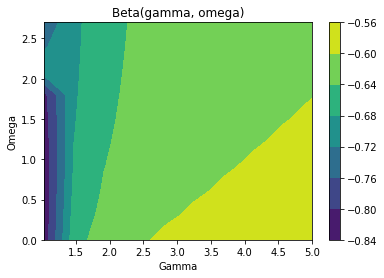

<Figure size 432x288 with 0 Axes>

In [3]:
b = [] #beta 
for i in range(len(Z)):
    b.append(Z[i]/(omega[i] + 1))

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, b)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Beta(gamma, omega)')
ax.set_xlabel('Gamma')
ax.set_ylabel('Omega')
plt.show()
plt.savefig("beta_plot.pdf")

large gamma:

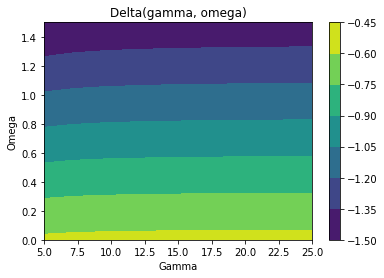

<Figure size 432x288 with 0 Axes>

In [4]:
import numpy as np
import matplotlib.pyplot as plt
gamma = numpy.linspace(5,25,10)
omega = np.array([0, 0.3, 0.6, 0.9, 1.2, 1.5])
X, Y = np.meshgrid(gamma, omega)
#Z = np.sqrt(X**2 + Y**2)
Z = np.array([[-0.57656338, -0.57014124, -0.56693688, -0.56501549, -0.56373486, -0.5628202,
 -0.56213422, -0.56160067, -0.56117383, -0.56082459],
              [-0.75881853, -0.75005621, -0.74566743, -0.74303022, -0.74127007, -0.74001173,
 -0.73906732, -0.73833238, -0.73774417, -0.73726273],
              [-0.94218144, -0.93107187, -0.92549294, -0.92213566, -0.91989283, -0.91828835,
 -0.91708359, -0.91614569, -0.91539481, -0.91478008],
              [-1.12624412, -1.11278699, -1.1060165,  -1.10193787, -1.09921128, -1.0972598,
 -1.09579397, -1.09465252, -1.09373849, -1.09299005], 
              [-1.31077673, -1.2949739,  -1.28701201, -1.28221184, -1.27900124, -1.27670253,
 -1.27497541, -1.27363022, -1.27255286, -1.27167057],
              [-1.49564002, -1.47749388, -1.4683413,  -1.46281985, -1.45912533, -1.45647939,
 -1.45449098, -1.45294202, -1.45170131, -1.45068514]])
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Delta(gamma, omega)')
ax.set_xlabel('Gamma')
ax.set_ylabel('Omega')
plt.show()
plt.savefig("Large_gamma.pdf")

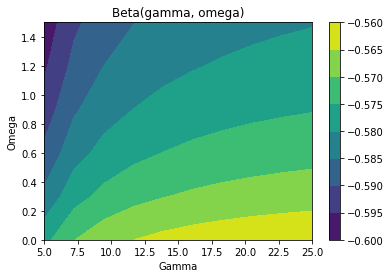

<Figure size 432x288 with 0 Axes>

In [5]:
b = [] #beta 
for i in range(len(Z)):
    b.append(Z[i]/(omega[i] + 1))

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, b)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Beta(gamma, omega)')
ax.set_xlabel('Gamma')
ax.set_ylabel('Omega')
plt.show()
plt.savefig("large_gamma_beta.pdf")

In [6]:
Z[2]/(omega[2] + 1)

array([-0.5888634 , -0.58191992, -0.57843309, -0.57633479, -0.57493302,
       -0.57393022, -0.57317724, -0.57259106, -0.57212176, -0.57173755])

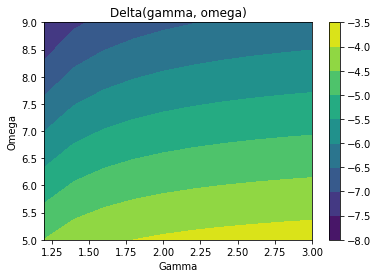

<Figure size 432x288 with 0 Axes>

In [7]:
import numpy as np
import matplotlib.pyplot as plt
gamma = numpy.array([1.2, 1.4, 1.6, 1.8, 2.,  2.2, 2.4, 2.6, 2.8, 3. ])
omega = np.array([5,6,7,8,9])
X, Y = np.meshgrid(gamma, omega)
#Z = np.sqrt(X**2 + Y**2)
Z = np.array([[-4.49199985, -4.23258323, -4.09145603, -3.99986388, -3.93480518, -3.88590301,
 -3.84766822, -3.81688643, -3.79153577, -3.77027455],
              [-5.25000862, -4.94797552, -4.7835378,  -4.67673842, -4.6008327,  -4.54374939,
 -4.49909992, -4.46314145, -4.43351871, -4.40866815],
              [-6.00809588, -5.66348522, -5.47575166, -5.35375443, -5.26700837, -5.20174899,
 -5.15068878, -5.1095568,  -5.07566457, -5.04722683],
              [-6.76623891, -6.37907492, -6.16805546, -6.03086681, -5.93328506, -5.8598531,
 -5.80238491, -5.75608163, -5.71792171, -5.68589832], 
              [-7.52442262, -7.09472156, -6.86042326, -6.70804782, -6.5996337,  -6.5180317,
 -6.45415751, -6.40268453, -6.36025825, -6.32465029]])
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Delta(gamma, omega)')
ax.set_xlabel('Gamma')
ax.set_ylabel('Omega')
plt.show()
plt.savefig("Large_omega.pdf")

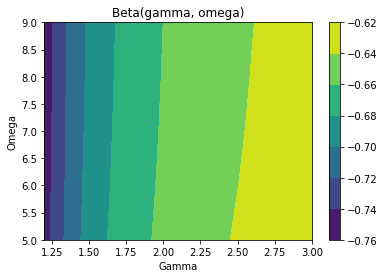

<Figure size 432x288 with 0 Axes>

In [8]:
b = [] #beta 
for i in range(len(Z)):
    b.append(Z[i]/(omega[i] + 1))

fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, b)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Beta(gamma, omega)')
ax.set_xlabel('Gamma')
ax.set_ylabel('Omega')
plt.show()
plt.savefig("large_omega_beta.pdf")

# Governing Equations

Mass conservation

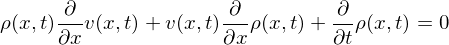

In [3]:
rho = sympy.Function('rho') # Density
v = sympy.Function('v') # Velocity
t = sympy.Symbol('t') # Time
x = sympy.Symbol('x') # Position
mass_conservation = sympy.Eq(sympy.Derivative(rho(x,t), t)+ sympy.Derivative(rho(x,t)*v(x,t),x),0).doit()
mass_conservation

Momentum conservation

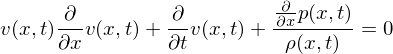

In [4]:
p = sympy.Function('p') # Pressure
momentum_conservation = sympy.Eq(sympy.Derivative(v(x,t),t)+v(x,t)*sympy.Derivative(v(x,t),x)+sympy.Derivative(p(x,t),x)/rho(x,t),0).doit()
momentum_conservation

Entropy conservation

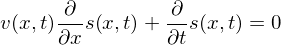

In [5]:
s = sympy.Function('s') # Entropy
entropy_conservation = sympy.Eq(sympy.Derivative(s(x,t),t)+v(x,t)*sympy.Derivative(s(x,t),x),0).doit()
entropy_conservation

Equation of state

In [6]:
gamma = sympy.Symbol('gamma') # Adiabatic index
eos = sympy.Eq(s(x,t), sympy.log(p(x,t))-gamma*sympy.log(rho(x,t)))
eos

# Reduction to dimensionless equations

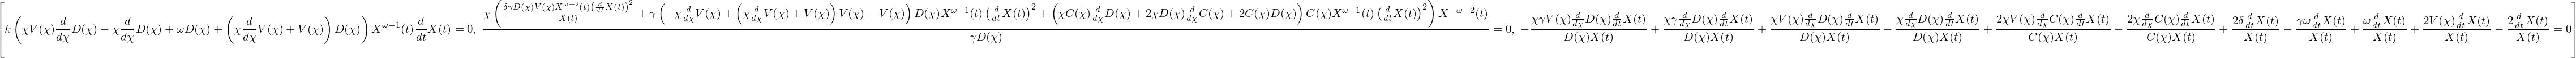

In [7]:
D = sympy.Function('D') # Dimensionless density
k = sympy.Symbol('k', positive=True) # density constant
omega = sympy.Symbol('omega') #density power law paraemter
X = sympy.Function('X') # Position of the shock front
c = sympy.Function('c') # Speed of sound
V = sympy.Function('V') # Dimensionless velocity
C = sympy.Function('C') # Dimensionless speed of sound 
chi = sympy.Symbol('chi') # Dimensionless position
delta = sympy.Symbol('delta', negative=True) # Shock velocity position power law index
temp = [mass_conservation, momentum_conservation, entropy_conservation.subs(eos.lhs,eos.rhs).doit()]
temp = [itm.subs(p(x,t), rho(x,t)*c(x,t)**2/gamma) for itm in temp]
temp = [itm.subs(rho(x,t), k*(X(t)**omega)*D(x/X(t))) for itm in temp] #updated density for stellar atmosphere
temp = [itm.subs(v(x,t), X(t).diff(t)*V(x/X(t))*x/X(t)) for itm in temp]
temp = [itm.subs(c(x,t), X(t).diff(t)*C(x/X(t))*x/X(t)) for itm in temp]
temp = [itm.subs(x, chi*X(t)) for itm in temp]
temp = [itm.doit() for itm in temp]
temp = [itm.simplify() for itm in temp]
temp = [itm.doit() for itm in temp]
temp = [itm.subs(X(t).diff(t,2), delta*X(t).diff(t)**2/X(t)) for itm in temp]
dimensionless_equation = temp
dimensionless_equation

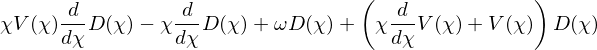

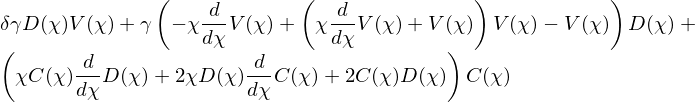

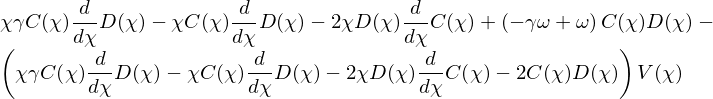

In [8]:
equation1 = D(chi) *(V(chi) + chi* V(chi).diff(chi)) + V(chi) *chi* D(chi).diff(chi) - chi *D(chi).diff(chi) + omega * D(chi)
display(equation1)
equation2 = C(chi)* (2* C(chi)* D(chi) + C(chi) *chi* D(chi).diff(chi) + 2 *D(chi) *chi *C(chi).diff(chi)) + D(chi) *V(chi) *delta *gamma + D(chi) *gamma *(V(chi) *(V(chi) + chi* V(chi).diff(chi)) - V(chi) - chi *V(chi).diff(chi))
display(equation2)
equation3 = (-gamma * omega + omega) * C(chi) * D(chi) + 2* C(chi)* D(chi) + C(chi)* chi *gamma* D(chi).diff(chi)  - V(chi)* (- 2* C(chi)* D(chi) + C(chi)* chi* gamma *D(chi).diff(chi) - C(chi) *chi* D(chi).diff(chi) - 2* D(chi) *chi *C(chi).diff(chi))  - (2 * C(chi)* D(chi) + C(chi) *chi* D(chi).diff(chi) + 2 * D(chi) *chi * C(chi).diff(chi))
display(equation3) 

\left( \left[\begin{matrix}\chi V{\left(\chi \right)} - \chi & \chi D{\left(\chi \right)} & 0\\\chi C^{2}{\left(\chi \right)} & \gamma \left(\chi V{\left(\chi \right)} - \chi\right) D{\left(\chi \right)} & 2 \chi C{\left(\chi \right)} D{\left(\chi \right)}\\\chi \gamma C{\left(\chi \right)} - \chi C{\left(\chi \right)} - \left(\chi \gamma C{\left(\chi \right)} - \chi C{\left(\chi \right)}\right) V{\left(\chi \right)} & 0 & 2 \chi D{\left(\chi \right)} V{\left(\chi \right)} - 2 \chi D{\left(\chi \right)}\end{matrix}\right], \  \left[\begin{matrix}- \omega D{\left(\chi \right)} - D{\left(\chi \right)} V{\left(\chi \right)}\\- \delta \gamma D{\left(\chi \right)} V{\left(\chi \right)} - \gamma \left(V^{2}{\left(\chi \right)} - V{\left(\chi \right)}\right) D{\left(\chi \right)} - 2 C^{2}{\left(\chi \right)} D{\left(\chi \right)}\\- \left(- \gamma \omega + \omega\right) C{\left(\chi \right)} D{\left(\chi \right)} - 2 C{\left(\chi \right)} D{\left(\chi \right)} V{\left(\chi \right)}\end{matri

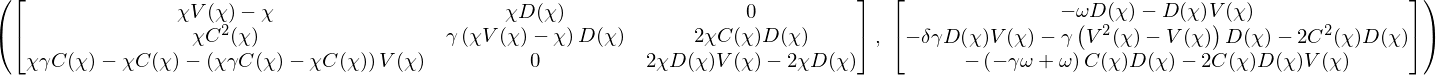

In [9]:
temp = [equation1, equation2, equation3]
d = sympy.Symbol('d')
v = sympy.Symbol('v')
c = sympy.Symbol('c')

temp = [itm.subs(D(chi).diff(chi), d).subs(V(chi).diff(chi), v).subs(C(chi).diff(chi), c) for itm in temp]
temp
print(sympy.latex(sympy.linear_eq_to_matrix(temp, [d, v, c])))
display(sympy.linear_eq_to_matrix(temp, [d, v, c]))

solving for the derivatives

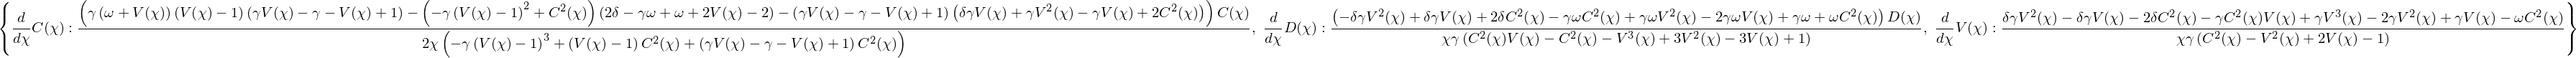

In [10]:
dimles_derivatives = sympy.solve(dimensionless_equation, [v(chi).diff(chi) for v in [D,C,V]])
dimles_derivatives

Safe places to cross the sonic line

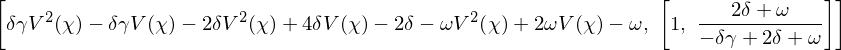

In [11]:
temp = V(chi).diff(chi).subs(dimles_derivatives)
temp = sympy.fraction(temp)[0]
temp = temp.subs(C(chi), 1-V(chi)).simplify()
#temp = temp.subs(omega, 1/(gamma - 1)) this still doesn't give a good substitution...
[temp, sympy.solve(temp, V(chi))] #looks ugly

Formulas for V_shock, C_shock: LONGER NOW...

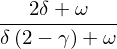

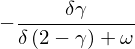

In [12]:
V_sonic = (2 *delta + omega)/(delta*(2-gamma) + omega)
C_sonic = -delta * gamma/(delta*(2-gamma) + omega)
display(V_sonic)
display(C_sonic)

It is possible to reduce these ODEs in $\chi$ to just one ode of $C$ vs $V$

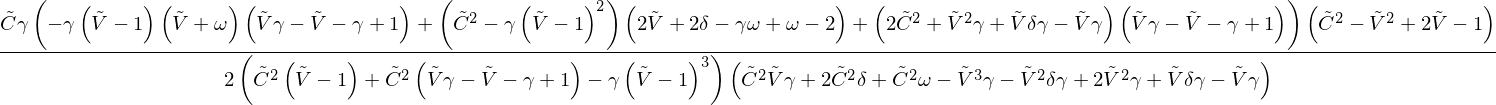

In [13]:
V_tilde = sympy.Symbol(r'\tilde{V}')
C_tilde = sympy.Symbol(r'\tilde{C}')
temp = C(chi).diff(chi)/V(chi).diff(chi)
temp = temp.subs(dimles_derivatives)
temp = temp.subs(V(chi), V_tilde)
temp = temp.subs(C(chi), C_tilde)
temp = temp.simplify()
dCdV = temp
dCdV

Slope at the safe sonic point crossing

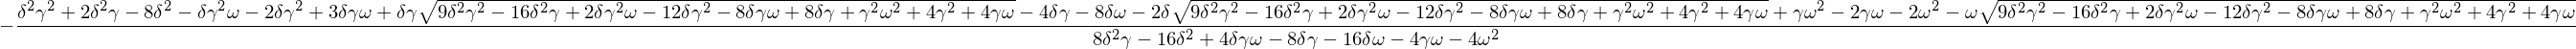

In [14]:
alpha = sympy.Symbol('alpha', positive=True) # Slope
DeltaV = sympy.Symbol(r'\Delta V', positive=True)
temp = dCdV.subs(C_tilde,C_sonic+alpha*DeltaV)
temp = temp.subs(V_tilde, V_sonic+DeltaV)
temp = sympy.fraction(temp)
temp = [sympy.diff(temp[0],DeltaV,2).subs(DeltaV,0).simplify(),
        sympy.diff(temp[1],DeltaV,2).subs(DeltaV,0).simplify()]
temp = temp[0]/temp[1]
sonic_line_slope = sympy.solve(alpha-temp,alpha)[1]
sonic_line_slope

Boundary conditions at the shock front

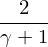

In [15]:
V_shock_front = 2/(gamma+1)
V_shock_front

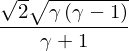

In [16]:
C_shock_front = sympy.sqrt(2*gamma*(gamma-1))/(gamma+1)
C_shock_front

# Shooting method

<IPython.core.display.Javascript object>


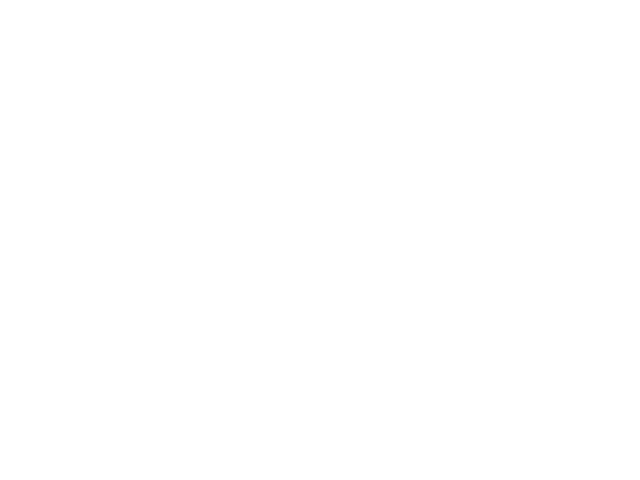

In [17]:
def shoot_from_sonic_point_case_1(dv, gv, ov):
    
    assert(gv<2)
    
    sonic_slope = sonic_line_slope.subs({gamma:gv,delta:dv,omega:ov})
    dV_init = 1e-6
    V_start = float(V_sonic.subs({gamma:gv,delta:dv,omega:ov})) + dV_init
    C_start = float(C_sonic.subs({gamma:gv,delta:dv,omega:ov})) + dV_init * float(sonic_slope)
    v_list = numpy.linspace(V_start, 10*V_start, 10000)
    c_list = C_start*numpy.ones_like(v_list)
    
    deriv = dCdV.subs({gamma:gv,delta:dv, omega:ov})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    
    for n in range(1,len(v_list)):
        delta_v = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + delta_v*wrapper(v_list[n-1], c_list[n-1])
        
    # Continue beyond the portal
    vbc = float(V_shock_front.subs(gamma,gv))
    v_list_2 = numpy.linspace(-v_list[-1], vbc,10000)
    c_list_2 = -c_list[-1]*numpy.ones_like(v_list_2)
    for n in range(1, len(v_list_2)):
        delta_v = v_list_2[n] - v_list_2[n-1]
        c_list_2[n] = c_list_2[n-1] + delta_v*wrapper(v_list_2[n-1], c_list_2[n-1])
    unified_v_list = numpy.concatenate((v_list, [numpy.nan], v_list_2))
    unified_c_list = numpy.concatenate((c_list, [numpy.nan], c_list_2))
    
    #if max(unified_c_list) > c_list_2[0] and max(unified_c_list) > c_list[-1]:
    #    print("Case 2:" + str(dv))
    #if min(unified_c_list) < c_list_2[0] and min(unified_c_list) < c_list[-1]:
    #    print("Case 2:" + str(dv))

    
    return numpy.vstack((unified_v_list, unified_c_list))

"""
#try monoatomic, adiabatic case
my_gamma = 1.1
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-0.9,-0.51,5):
    temp = shoot_from_sonic_point_case_1(dvalue, my_gamma, 0.01)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], 1-temp[0], 'k', linewidth=4)
pylab.scatter([float(V_shock_front.subs(gamma, my_gamma))],
           [float(C_shock_front.subs(gamma, my_gamma))], c='k', marker='o', s=50, label='front')
pylab.legend(loc='best')
pass
"""
#try monoatomic, adiabatic case
my_gamma = 1.47111111
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-1,-0.72,3):
    temp = shoot_from_sonic_point_case_1(dvalue, my_gamma, 0.3)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], 1-temp[0], 'k', linewidth=4, label='sonic')
pylab.scatter([float(V_shock_front.subs(gamma, my_gamma))],
           [float(C_shock_front.subs(gamma, my_gamma))], c='k', marker='o', s=50, label='front')
pylab.legend(loc='best')

pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')
pylab.tight_layout()
pylab.savefig("case_1")

pass


<IPython.core.display.Javascript object>


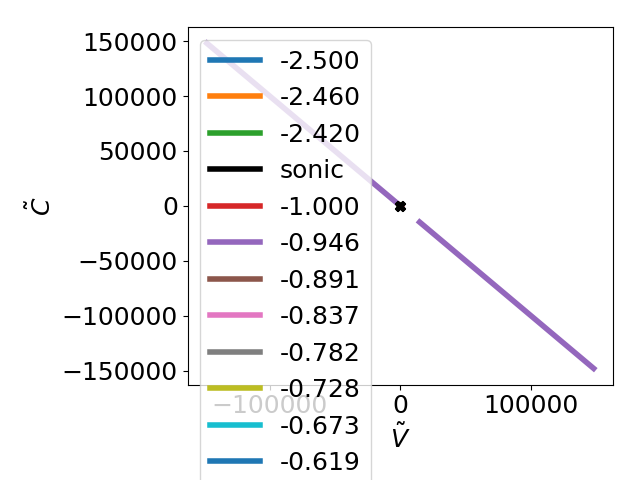

In [18]:
def shoot_from_sonic_point_case_2(dv, gv, ov):
    
    assert(gv>2)
    
    dV_init = 1e-6
    sonic_slope = sonic_line_slope.subs({gamma:gv,delta:dv,omega:ov})
    V_start = float(V_sonic.subs({gamma:gv,delta:dv,omega:ov})) + dV_init
    C_start = float(C_sonic.subs({gamma:gv,delta:dv,omega:ov})) + dV_init * float(sonic_slope)
    vbc = float(V_shock_front.subs(gamma,gv))
    v_list = numpy.linspace(V_start, vbc, 10000)
    c_list = C_start*numpy.ones_like(v_list)
    
    deriv = dCdV.subs({gamma:gv,delta:dv,omega:ov})
    wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)
    
    for n in range(1,len(v_list)):
        delta_v = v_list[n] - v_list[n-1]
        c_list[n] = c_list[n-1] + delta_v*wrapper(v_list[n-1], c_list[n-1])
    
    return numpy.vstack((v_list, c_list))

"""
my_gamma = 3.5
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-0.95,-0.51, 5):
    temp = shoot_from_sonic_point_case_2(dvalue, my_gamma)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], 1-temp[0], 'k', linewidth=4, label='sonic')
pylab.scatter([float(V_shock_front.subs(gamma, my_gamma))],
           [float(C_shock_front.subs(gamma, my_gamma))], c='k', marker='X', s=50, label='front', zorder=3)

pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')
pylab.tight_layout()
pylab.legend(loc='best')
pass
"""

my_gamma = 3.5
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-2.5,-2.42, 3):
    temp = shoot_from_sonic_point_case_2(dvalue, my_gamma, 3)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], 1-temp[0], 'k', linewidth=4, label='sonic')
pylab.scatter([float(V_shock_front.subs(gamma, my_gamma))],
           [float(C_shock_front.subs(gamma, my_gamma))], c='k', marker='X', s=50, label='front', zorder=3)

pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')

pylab.legend(loc='best')
pylab.tight_layout()
pylab.savefig("case_2")

In [19]:
def overall_method(dv, gv, ov):
    
    if(gv < 2) and (dv < ov/(gv - 2)):
            sonic_slope = sonic_line_slope.subs({gamma:gv,delta:dv,omega:ov})
            dV_init = 1e-6
            V_start = float(V_sonic.subs({gamma:gv,delta:dv,omega:ov})) + dV_init
            C_start = float(C_sonic.subs({gamma:gv,delta:dv,omega:ov})) + dV_init * float(sonic_slope)
            v_list = numpy.linspace(V_start, 10*V_start, 10000)
            c_list = C_start*numpy.ones_like(v_list)

            deriv = dCdV.subs({gamma:gv,delta:dv, omega:ov})
            wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)

            for n in range(1,len(v_list)):
                delta_v = v_list[n] - v_list[n-1]
                c_list[n] = c_list[n-1] + delta_v*wrapper(v_list[n-1], c_list[n-1])

            # Continue beyond the portal
            vbc = float(V_shock_front.subs(gamma,gv))
            v_list_2 = numpy.linspace(-v_list[-1], vbc,10000)
            c_list_2 = -c_list[-1]*numpy.ones_like(v_list_2)
            for n in range(1, len(v_list_2)):
                delta_v = v_list_2[n] - v_list_2[n-1]
                c_list_2[n] = c_list_2[n-1] + delta_v*wrapper(v_list_2[n-1], c_list_2[n-1])
            unified_v_list = numpy.concatenate((v_list, [numpy.nan], v_list_2))
            unified_c_list = numpy.concatenate((c_list, [numpy.nan], c_list_2))

            return numpy.vstack((unified_v_list, unified_c_list))
    else:
        dV_init = 1e-6
        sonic_slope = sonic_line_slope.subs({gamma:gv,delta:dv,omega:ov})
        V_start = float(V_sonic.subs({gamma:gv,delta:dv,omega:ov})) + dV_init
        C_start = float(C_sonic.subs({gamma:gv,delta:dv,omega:ov})) + dV_init * float(sonic_slope)
        vbc = float(V_shock_front.subs(gamma,gv))
        v_list = numpy.linspace(V_start, vbc, 10000)
        c_list = C_start*numpy.ones_like(v_list)

        deriv = dCdV.subs({gamma:gv,delta:dv,omega:ov})
        wrapper = sympy.lambdify([V_tilde,C_tilde], deriv)

        for n in range(1,len(v_list)):
            delta_v = v_list[n] - v_list[n-1]
            c_list[n] = c_list[n-1] + delta_v*wrapper(v_list[n-1], c_list[n-1])

        return numpy.vstack((v_list, c_list))
    

my_gamma = 1.471111
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-1,-0.51, 10):
    temp = overall_method(dvalue, my_gamma, 0.5)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], 1-temp[0], 'k', linewidth=4, label='sonic')
pylab.scatter([float(V_shock_front.subs(gamma, my_gamma))],
           [float(C_shock_front.subs(gamma, my_gamma))], c='k', marker='X', s=50, label='front', zorder=3)

pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')
pylab.tight_layout()
pylab.legend(loc='best')


<IPython.core.display.Javascript object>


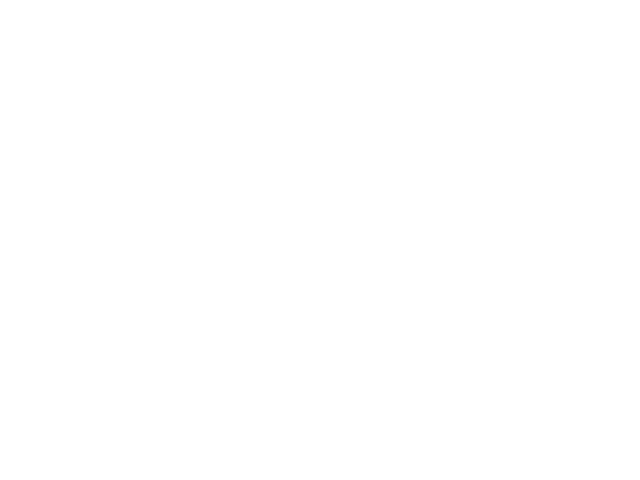

In [28]:
my_gamma = 1.91222222
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-1,-0.6,5):
    temp = overall_method(dvalue, my_gamma, 0.1)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], 1-temp[0], 'k', linewidth=4, label='sonic')
pylab.scatter([float(V_shock_front.subs(gamma, my_gamma))],
           [float(C_shock_front.subs(gamma, my_gamma))], c='k', marker='X', s=50, label='front', zorder=3)

#pylab.xlabel(r'$\tilde{V}$')
pylab.ylabel(r'$\tilde{C}$')
pylab.tight_layout()
pylab.legend(loc='best')

In [80]:
delta_list
omega_list = [0.5, 0.75, 1., 1.25, 1.5 , 1.75, 2., 2.25, 2.5, 2.75]


In [69]:
gamma_val = 3
omega_list = [0.5, 0.75, 1., 1.25, 1.5 , 1.75, 2., 2.25, 2.5, 2.75]
for n, omega_value in enumerate(omega_list):
    function_for_bisection = lambda dvalue: overall_method(dvalue, gamma_val, omega_value)[1][-1] - float(C_shock_front.subs(gamma,gamma_val))
    print(omega_value)
    print(gamma_val)
    delta_list.append(scipy.optimize.bisect(function_for_bisection, -1,-0.5))

2.25
2.5
2.75


Combine the below 2 cases into 1 case

In [29]:
#gamma_list = numpy.linspace(2,3,10)
gamma_list = [5./3.]
delta_list = numpy.zeros_like(gamma_list)
for n, gamma_value in enumerate(gamma_list):
    function_for_bisection = lambda dvalue: overall_method(dvalue, gamma_value, 1.5)[1][-1] - float(C_shock_front.subs(gamma,gamma_value))
    delta_list[n] = scipy.optimize.bisect(function_for_bisection, -3.5,-1)
#gamma_value = 1.03
#function_for_bisection = lambda dvalue: overall_method(dvalue, gamma_value, 2.7)[1][-1] - float(C_shock_front.subs(gamma,gamma_value))
#delta_list[0] = scipy.optimize.bisect(function_for_bisection, -2.8,-2)

In [47]:
delta_list = []
delta_list

TypeError: can't convert complex to float

In [74]:
print(omega_list)
print(delta_list)

[2.25, 2.5, 2.75]
[-0.9062510422225387, -1.0641059777608461, -1.222346633547204, -1.380867457095519, -1.539598156885404, -1.6984901203668414, -1.857508659179075, -2.0166283597736765, -2.175830179648983, -2.335099569789236]


<IPython.core.display.Javascript object>


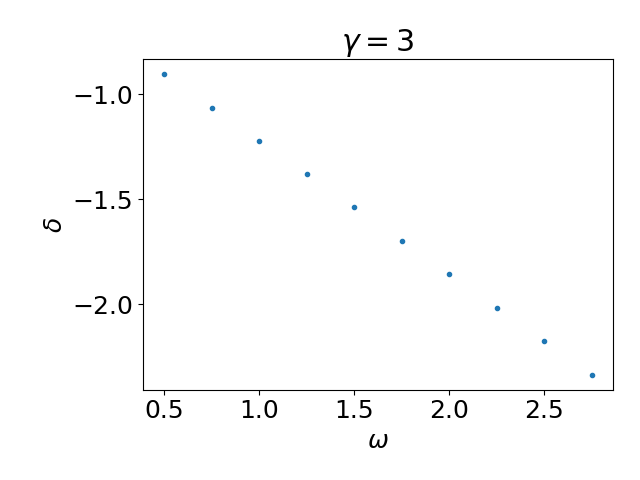

In [81]:
matplotlib.rcParams.update({'font.size': 18})
pylab.plot(omega_list, delta_list, '.')
pylab.xlabel(r'$\omega$')
pylab.ylabel(r'$\delta$')
pylab.title(r'$\gamma = 3$')
pylab.tight_layout()
pylab.savefig("gamma=3")

# Infinite $\gamma$

The problem with the limit $\gamma \rightarrow \infty$ is that $\tilde{V}$ changes over a very narrow range. If we define a new variable $W = \gamma V$, when the integration domain of this new variable remains finite in the limit $\gamma \rightarrow \infty$. The derivative in terms of the new variable is

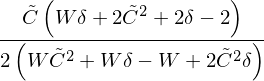

In [30]:
W = sympy.Symbol('W', positive=True)
temp = dCdV
temp = temp.subs(V_tilde,W/gamma)
temp = sympy.series(temp,gamma,sympy.oo,0)
temp = temp.removeO()
temp = temp/gamma
temp = temp.simplify()
dCdW = temp
dCdW.subs(omega, 0)

In [31]:
dCdW.subs(delta,0).subs(omega, 0).simplify()

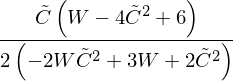

In [32]:
dCdW.subs(delta,sympy.Rational(-1,2)).subs(omega, 0).simplify()

Slope at the sonic point

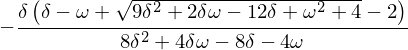

In [33]:
beta = sympy.Symbol('beta', positive=True) # Slope
temp = dCdV.subs(C_tilde,C_sonic+alpha*DeltaV)
temp = temp.subs(V_tilde, V_sonic+DeltaV)
temp = sympy.fraction(temp)
temp = [sympy.diff(temp[0],DeltaV,2).subs(DeltaV,0).simplify(),
        sympy.diff(temp[1],DeltaV,2).subs(DeltaV,0).simplify()]
temp = temp[0]/temp[1]
temp = temp.subs(alpha, gamma*beta)
temp = temp/gamma
temp = temp.series(gamma,sympy.oo,1)
temp = temp.removeO()
temp = temp.simplify()
temp = sympy.solve(temp-beta,beta)[1]
infinite_gamma_sonic_slope = temp
infinite_gamma_sonic_slope

omega = 0 case:

In [34]:
"""
def infinite_gamma_shoot_forward(dvalue):
        
    sonic_slope = infinite_gamma_sonic_slope.subs({omega:0,delta:dvalue})
    dV_init = 1e-3
    W_start = -2.0 + dV_init
    C_start = 1.0 + dV_init * float(sonic_slope)
    w_list = numpy.linspace(W_start, 2, 100000)
    c_list = C_start*numpy.ones_like(w_list)
    
    deriv = dCdW.subs({omega:0,delta:dvalue})
    wrapper = sympy.lambdify([W,C_tilde], deriv)
    
    for n in range(1,len(w_list)):
        delta_w = w_list[n] - w_list[n-1]
        c_list[n] = c_list[n-1] + delta_w*wrapper(w_list[n-1], c_list[n-1])
            
    return numpy.vstack((w_list, c_list))
"""

'\ndef infinite_gamma_shoot_forward(dvalue):\n        \n    sonic_slope = infinite_gamma_sonic_slope.subs({omega:0,delta:dvalue})\n    dV_init = 1e-3\n    W_start = -2.0 + dV_init\n    C_start = 1.0 + dV_init * float(sonic_slope)\n    w_list = numpy.linspace(W_start, 2, 100000)\n    c_list = C_start*numpy.ones_like(w_list)\n    \n    deriv = dCdW.subs({omega:0,delta:dvalue})\n    wrapper = sympy.lambdify([W,C_tilde], deriv)\n    \n    for n in range(1,len(w_list)):\n        delta_w = w_list[n] - w_list[n-1]\n        c_list[n] = c_list[n-1] + delta_w*wrapper(w_list[n-1], c_list[n-1])\n            \n    return numpy.vstack((w_list, c_list))\n'

Any omega case:

<IPython.core.display.Javascript object>


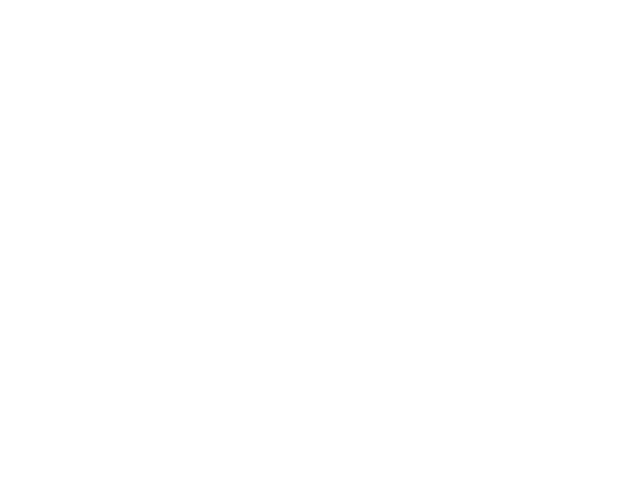

In [35]:
def infinite_gamma_shoot_forward(ovalue, dvalue):
        
    sonic_slope = infinite_gamma_sonic_slope.subs({omega:ovalue,delta:dvalue})
    dV_init = 1e-3
    W_start = -2.0 - ovalue/dvalue + dV_init
    C_start = 1.0 + dV_init * float(sonic_slope)
    w_list = numpy.linspace(W_start, 2, 100000)
    c_list = C_start*numpy.ones_like(w_list)
    
    deriv = dCdW.subs({omega:ovalue,delta:dvalue})
    wrapper = sympy.lambdify([W,C_tilde], deriv)
    
    for n in range(1,len(w_list)):
        delta_w = w_list[n] - w_list[n-1]
        c_list[n] = c_list[n-1] + delta_w*wrapper(w_list[n-1], c_list[n-1])
            
    return numpy.vstack((w_list, c_list))

%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-0.6,-0.5,5):
    temp = infinite_gamma_shoot_forward(0, dvalue)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], numpy.ones_like(temp[0]), 'k', linewidth=4)
pylab.scatter([2],
           [numpy.sqrt(2.0)], c='k', marker='o', s=50, label='front')
pylab.legend(loc='best')
pylab.xlabel('W')
pylab.ylabel('C')
pylab.title(r'$\gamma\rightarrow\infty$')
pylab.tight_layout()
pass

<IPython.core.display.Javascript object>


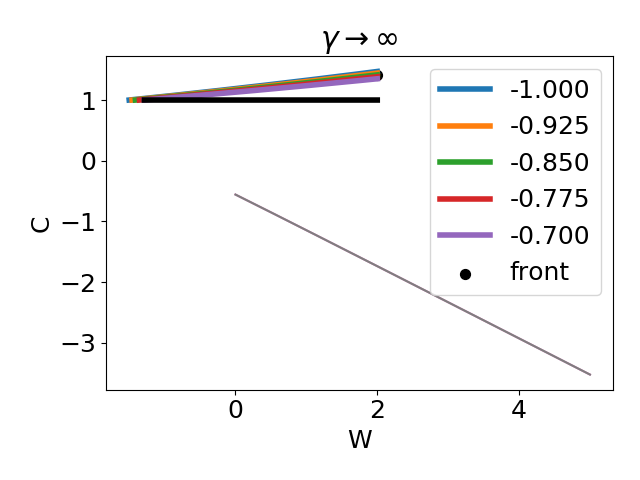

In [36]:
%matplotlib notebook
matplotlib.rcParams.update({'font.size': 18})
for dvalue in numpy.linspace(-1,-0.7,5):
    temp = infinite_gamma_shoot_forward(0.5, dvalue)
    pylab.plot(temp[0], temp[1], linewidth=4, label="{:1.3f}".format(dvalue))
pylab.plot(temp[0], numpy.ones_like(temp[0]), 'k', linewidth=4)
pylab.scatter([2],
           [numpy.sqrt(2.0)], c='k', marker='o', s=50, label='front')
pylab.legend(loc='best')
pylab.xlabel('W')
pylab.ylabel('C')
pylab.title(r'$\gamma\rightarrow\infty$')
pylab.tight_layout()
pass

In [37]:
numpy.linspace(0, 5, 10)

array([0.        , 0.55555556, 1.11111111, 1.66666667, 2.22222222,
       2.77777778, 3.33333333, 3.88888889, 4.44444444, 5.        ])

Determining $\lim_{\gamma\rightarrow \infty} \delta(\omega, \gamma)$

In [38]:
#function_for_bisection = lambda dvalue: infinite_gamma_shoot_forward(0, dvalue)[1][-1] - numpy.sqrt(2)
#infinite_gamma_delta = scipy.optimize.bisect(function_for_bisection, -0.6,-0.5)
#infinite_gamma_delta

In [41]:
omega_list = numpy.linspace(0, 5, 10)
#omega_list = [0.5]
delta_list = []

for i in omega_list:
    print(i)
    function_for_bisection = lambda dvalue: infinite_gamma_shoot_forward(i, dvalue)[1][-1] - numpy.sqrt(2)
    infinite_gamma_delta = scipy.optimize.bisect(function_for_bisection, -5,-0.5)
    delta_list.append(infinite_gamma_delta)
    print(infinite_gamma_delta)
    
print(delta_list)

0.0
-0.5573297792501535
0.5555555555555556
-0.8824612649490291
1.1111111111111112
-1.210221855720306
1.6666666666666667
-1.5392806294706816
2.2222222222222223
-1.8690740095818228
2.7777777777777777
-2.1993229984640266
3.3333333333333335
-2.5298738542240926
3.8888888888888893
-2.8606349496659504
4.444444444444445
-3.191548303404147
5.0
-3.522575444772542
[-0.5573297792501535, -0.8824612649490291, -1.210221855720306, -1.5392806294706816, -1.8690740095818228, -2.1993229984640266, -2.5298738542240926, -2.8606349496659504, -3.191548303404147, -3.522575444772542]


<IPython.core.display.Javascript object>


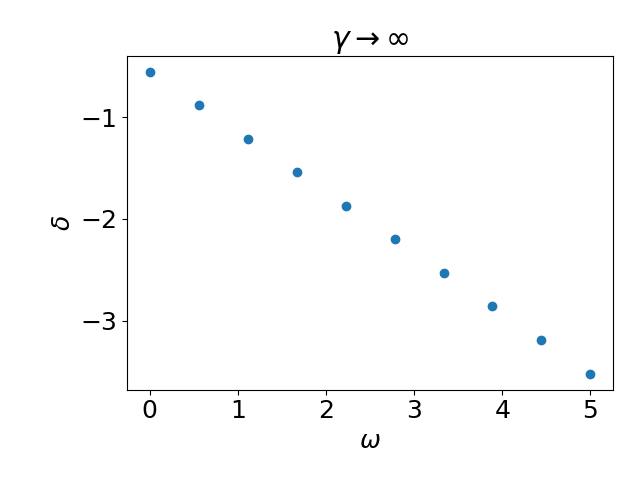

In [48]:
%matplotlib notebook
pylab.scatter(omega_list, delta_list)
pylab.xlabel(r'$\omega$')
pylab.ylabel(r'$\delta$')
pylab.title(r'$\gamma\rightarrow\infty$')
pylab.tight_layout()
pass

# Infinite $\omega$


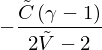

In [29]:
temp = dCdV
temp = sympy.series(temp,omega,sympy.oo,1)
temp = temp.removeO()
temp = temp.simplify()
dCdV_w = temp
#dCdV_w.subs(omega, 0)
dCdV_w #no delta...

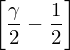

In [27]:
#beta = sympy.Symbol('beta', positive=True) # Slope
temp = dCdV.subs(C_tilde,C_sonic+alpha*DeltaV)
temp = temp.subs(V_tilde, V_sonic+DeltaV)
temp = sympy.fraction(temp)
temp = [sympy.diff(temp[0],DeltaV,2).subs(DeltaV,0).simplify(),
        sympy.diff(temp[1],DeltaV,2).subs(DeltaV,0).simplify()]
temp = temp[0]/temp[1]
temp = temp.series(omega,sympy.oo,1)
temp = temp.removeO()
temp = temp.simplify()
temp = sympy.solve(temp-alpha,alpha)
infinite_omega_sonic_slope = temp
infinite_omega_sonic_slope

In [ ]:
def infinite_omega_shoot_forward(gvalue, dvalue):
        
    sonic_slope = infinite_omega_sonic_slope.subs({gamma:gvalue})
    dV_init = 1e-3
    V_start = 1/dvalue + dV_init
    C_start = dV_init * float(sonic_slope)
    v_list = numpy.linspace(V_start, 2, 100000)
    c_list = C_start*numpy.ones_like(w_list)
    
    deriv = dCdV_w.subs({gamma:g_value})
    wrapper = sympy.lambdify([W,C_tilde], deriv)
    
    for n in range(1,len(w_list)):
        delta_w = w_list[n] - w_list[n-1]
        c_list[n] = c_list[n-1] + delta_w*wrapper(w_list[n-1], c_list[n-1])
            
    return numpy.vstack((w_list, c_list))

